**Задание:**  
1. Сформировать или скачать семантический граф
2. Реализовать модель GCN применительно к этому графу для классификации вершин графа
3. Сравнить качество полученной модели с другими моделями

In [ ]:
pip install torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 46.5 MB/s eta 0:00:00


In [ ]:
pip install pyvis

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 48.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 76.6 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.datasets import WikiCS
from torch_geometric.nn import GCNConv, GATConv, SAGEConv
import matplotlib.pyplot as plt
from pyvis.network import Network
import networkx as nx
from torch_geometric.utils import to_networkx

## Загрузка датасета:  
Набор данных состоит из узлов, соответствующих статьям по информатике, рёбер, основанных на гиперссылках, и 10 классов, представляющих различные направления в этой области.

In [ ]:
dataset = WikiCS(root='data/WikiCS')
data = dataset[0]
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = data.to(device)

/usr/local/lib/python3.11/dist-packages/torch_geometric/datasets/wikics.py:45: UserWarning: The WikiCS dataset now returns an undirected graph by default. Please explicitly specify 'is_undirected=False' to restore the old behavior.
  warnings.warn(
Processing...
Done!


In [ ]:
data

Data(x=[11701, 300], edge_index=[2, 431726], y=[11701], train_mask=[11701, 20], val_mask=[11701, 20], test_mask=[11701], stopping_mask=[11701, 20])

In [ ]:
G = to_networkx(data, to_undirected=True)

In [ ]:
net = Network(notebook=False, height="800px", width="100%", bgcolor="#222222", font_color="white")

In [ ]:
# Ограничим количество узлов, чтобы не перегружать визуализацию
max_nodes = 500
subgraph_nodes = list(G.nodes())[:max_nodes]
H = G.subgraph(subgraph_nodes)
node_labels = data.y.cpu().numpy()

In [ ]:
node_labels

array([7, 2, 2, ..., 2, 5, 7])

In [ ]:
colors = [
    '#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231',
    '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe'
]

In [ ]:
for node in H.nodes():
    label = f"Node {node}, Class {node_labels[node]}"
    net.add_node(
        n_id=node,
        label=label,
        title=f"Article ID: {node}, Class: {node_labels[node]}",
        color=colors[node_labels[node] % len(colors)]
    )

In [ ]:
# Добавляем рёбра
for source, target in H.edges():
    net.add_edge(source, target)

In [ ]:
net.write_html("wiki_cs_graph.html")

## GCN

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = data.to(device)

In [ ]:
class GCN(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

In [ ]:
split = 0
model = GCN(dataset.num_node_features, 64, dataset.num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

In [ ]:
losses_gat = []
train_accuracies = []
test_accuracies = []
model.train()
for epoch in range(200):
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    train_mask = data.train_mask[:, split] if data.train_mask.ndimension() > 1 else data.train_mask
    loss = F.nll_loss(out[train_mask], data.y[train_mask])
    loss.backward()
    optimizer.step()

    # Точность на тренировочных данных
    pred_train = out.argmax(dim=1)[train_mask]
    correct_train = pred_train == data.y[train_mask]
    train_acc = correct_train.sum().item() / train_mask.sum().item()

    # Точность на тестовых данных
    test_mask = data.test_mask
    pred_test = out.argmax(dim=1)[test_mask]
    correct_test = pred_test == data.y[test_mask]
    test_acc = correct_test.sum().item() / test_mask.sum().item()

    losses_gat.append(loss.item())
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)

    if epoch % 20 == 0:
        print(f'Epoch {epoch}, Train Accuracy: {train_acc:.4f}, Test Accuracy: {test_acc:.4f}')

Epoch 0, Train Accuracy: 0.0259, Test Accuracy: 0.0217
Epoch 20, Train Accuracy: 0.6638, Test Accuracy: 0.6562
Epoch 40, Train Accuracy: 0.7672, Test Accuracy: 0.7388
Epoch 60, Train Accuracy: 0.8034, Test Accuracy: 0.7602
Epoch 80, Train Accuracy: 0.8293, Test Accuracy: 0.7657
Epoch 100, Train Accuracy: 0.8293, Test Accuracy: 0.7749
Epoch 120, Train Accuracy: 0.8517, Test Accuracy: 0.7772
Epoch 140, Train Accuracy: 0.8552, Test Accuracy: 0.7775
Epoch 160, Train Accuracy: 0.8621, Test Accuracy: 0.7707
Epoch 180, Train Accuracy: 0.8690, Test Accuracy: 0.7780


In [ ]:
model.eval()
with torch.no_grad():
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)

    test_mask = data.test_mask
    correct = pred[test_mask] == data.y[test_mask]
    acc = correct.sum().item() / test_mask.sum().item()

print(f'GCN Accuracy: {acc:.4f}')

GCN Accuracy: 0.7893


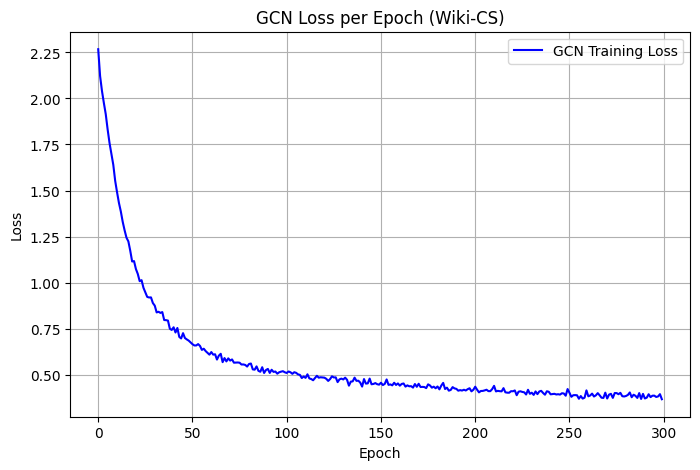

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(losses, label='GCN Training Loss', color='blue')
plt.title('GCN Loss per Epoch (Wiki-CS)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

# GAT

In [ ]:
class GAT(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GATConv(in_channels, hidden_channels, heads=2)
        self.conv2 = GATConv(2 * hidden_channels, out_channels, heads=1)

    def forward(self, x, edge_index):
        x = F.elu(self.conv1(x, edge_index))
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

In [ ]:
split = 0
model = GAT(dataset.num_node_features, 64, dataset.num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

In [ ]:
losses_gat = []
train_accuracies = []
test_accuracies = []
model.train()
for epoch in range(200):
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    train_mask = data.train_mask[:, split] if data.train_mask.ndimension() > 1 else data.train_mask
    loss = F.nll_loss(out[train_mask], data.y[train_mask])
    loss.backward()
    optimizer.step()

    # Точность на тренировочных данных
    pred_train = out.argmax(dim=1)[train_mask]
    correct_train = pred_train == data.y[train_mask]
    train_acc = correct_train.sum().item() / train_mask.sum().item()

    # Точность на тестовых данных
    test_mask = data.test_mask
    pred_test = out.argmax(dim=1)[test_mask]
    correct_test = pred_test == data.y[test_mask]
    test_acc = correct_test.sum().item() / test_mask.sum().item()

    losses_gat.append(loss.item())
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)

    if epoch % 20 == 0:
        print(f'Epoch {epoch}, Train Accuracy: {train_acc:.4f}, Test Accuracy: {test_acc:.4f}')

Epoch 0, Train Accuracy: 0.0983, Test Accuracy: 0.0936
Epoch 20, Train Accuracy: 0.7897, Test Accuracy: 0.7595
Epoch 40, Train Accuracy: 0.8431, Test Accuracy: 0.7818
Epoch 60, Train Accuracy: 0.8690, Test Accuracy: 0.7854
Epoch 80, Train Accuracy: 0.8914, Test Accuracy: 0.7814
Epoch 100, Train Accuracy: 0.9293, Test Accuracy: 0.7850
Epoch 120, Train Accuracy: 0.9293, Test Accuracy: 0.7794
Epoch 140, Train Accuracy: 0.9552, Test Accuracy: 0.7790
Epoch 160, Train Accuracy: 0.9586, Test Accuracy: 0.7695
Epoch 180, Train Accuracy: 0.9672, Test Accuracy: 0.7823


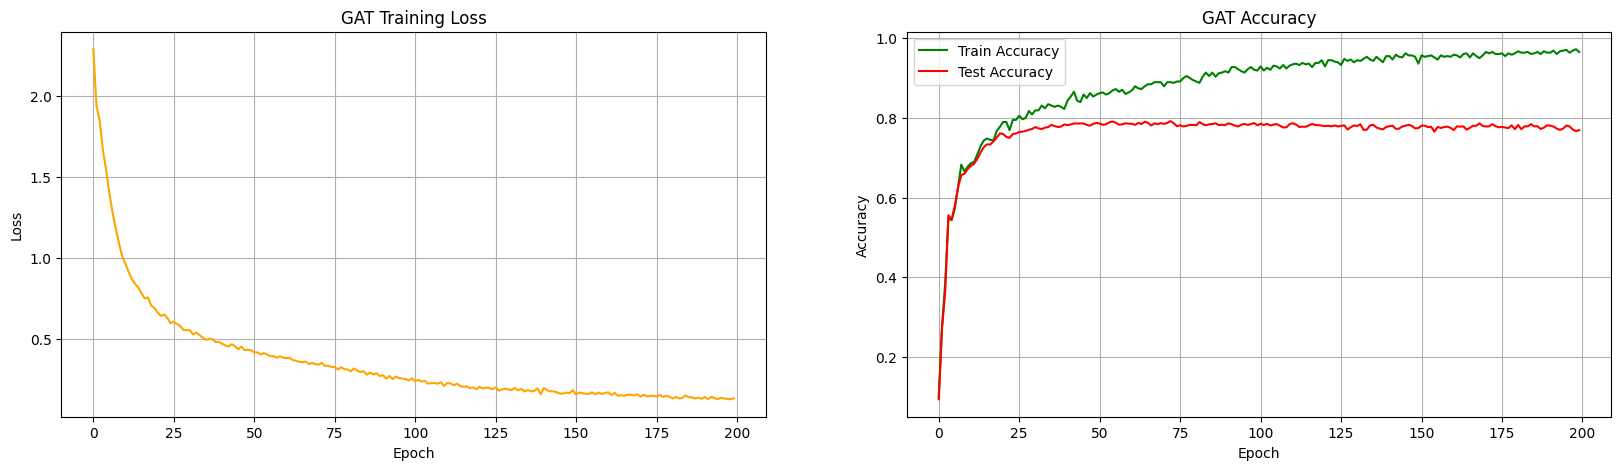

In [ ]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.plot(losses_gat, label='GAT Loss', color='orange')
plt.title('GAT Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy', color='green')
plt.plot(test_accuracies, label='Test Accuracy', color='red')
plt.title('GAT Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

plt.show()

# GraphSAGE

In [ ]:
class GraphSAGE(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

In [ ]:
split = 0
model = GraphSAGE(dataset.num_node_features, 64, dataset.num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

In [ ]:
losses_sage = []
train_accuracies = []
test_accuracies = []
model.train()
for epoch in range(200):
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    train_mask = data.train_mask[:, split] if data.train_mask.ndimension() > 1 else data.train_mask
    loss = F.nll_loss(out[train_mask], data.y[train_mask])
    loss.backward()
    optimizer.step()

    # Точность на тренировочных данных
    pred_train = out.argmax(dim=1)[train_mask]
    correct_train = pred_train == data.y[train_mask]
    train_acc = correct_train.sum().item() / train_mask.sum().item()

    # Точность на тестовых данных
    test_mask = data.test_mask
    pred_test = out.argmax(dim=1)[test_mask]
    correct_test = pred_test == data.y[test_mask]
    test_acc = correct_test.sum().item() / test_mask.sum().item()

    losses_sage.append(loss.item())
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)

    if epoch % 20 == 0:
        print(f'Epoch {epoch}, Train Accuracy: {train_acc:.4f}, Test Accuracy: {test_acc:.4f}')

Epoch 0, Train Accuracy: 0.0552, Test Accuracy: 0.0547
Epoch 20, Train Accuracy: 0.7621, Test Accuracy: 0.7158
Epoch 40, Train Accuracy: 0.8379, Test Accuracy: 0.7681
Epoch 60, Train Accuracy: 0.8655, Test Accuracy: 0.7761
Epoch 80, Train Accuracy: 0.9052, Test Accuracy: 0.7770
Epoch 100, Train Accuracy: 0.9224, Test Accuracy: 0.7772
Epoch 120, Train Accuracy: 0.9431, Test Accuracy: 0.7688
Epoch 140, Train Accuracy: 0.9638, Test Accuracy: 0.7778
Epoch 160, Train Accuracy: 0.9586, Test Accuracy: 0.7655
Epoch 180, Train Accuracy: 0.9793, Test Accuracy: 0.7727


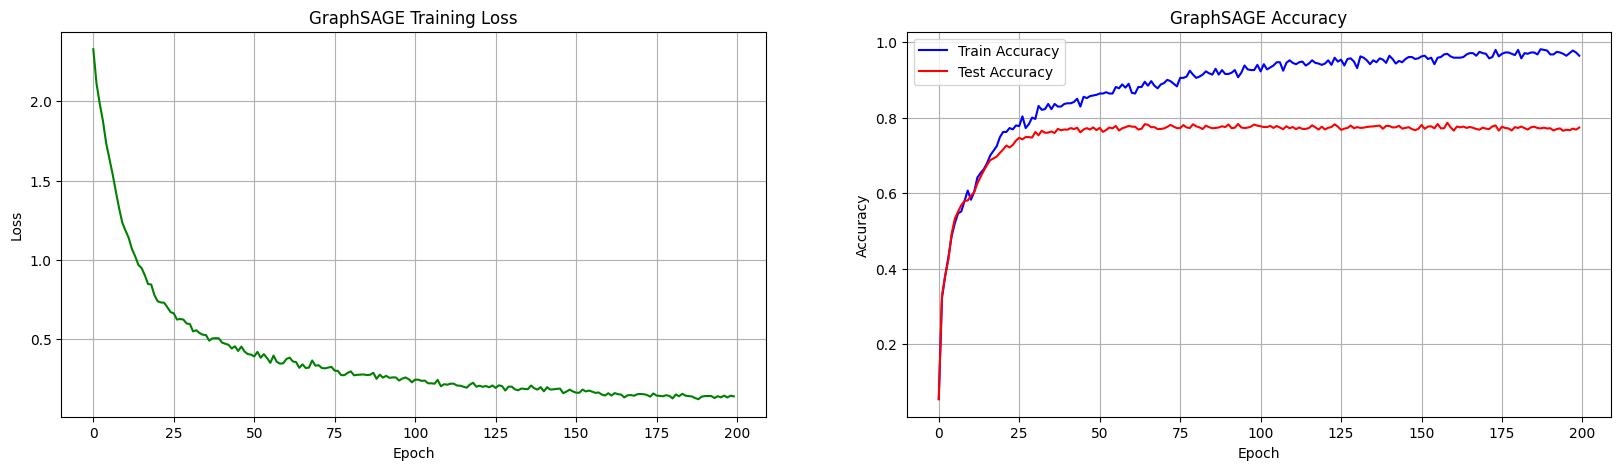

In [ ]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.plot(losses_sage, label='GraphSAGE Loss', color='green')
plt.title('GraphSAGE Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy', color='blue')
plt.plot(test_accuracies, label='Test Accuracy', color='red')
plt.title('GraphSAGE Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

plt.show()